Имея решение `1d`  задачи для двух жидкостей, можем получить `2d` решение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display

In [2]:
def two_dim_index_to_one(i: int, j: int, ny: int) -> int:
    return ny * i + j
def one_d_index_to_two(one_d: int, ny: int):
    i = int(one_d / ny)
    j = one_d % ny
    return i, j

In [3]:
nx = 25
ny = 25
k = 1e-1 * 1.987e-13  # 1 darcy to m^2
dx = 3 # m
dy = 3 # m
phi = 0.4
p_0 = 150 * 10 ** 5  # psi to Pa
d = 10  # m
dt = 30  # s
s_0 = 0.4
s_b = 0.1
p = np.ones((nx*ny, 1)) * p_0
s_o = np.ones((nx*ny, 1)) * s_0
s_w = np.ones((nx*ny, 1))* (1 - s_0)

Перейдём к сжимаемости для [rock](https://www.sciencedirect.com/topics/engineering/formation-compressibility), [water and oil](http://www.fekete.com/san/webhelp/feketeharmony/harmony_webhelp/content/html_files/reference_material/general_concepts/reservoir_properties.htm)

In [4]:
c_w = 1e-6 # # Pa^-1
c_o = 1e-6 # # Pa^-1
c_r = 3e-6 #  Pa^-1 

Также различаются вязкости [oil](https://petrowiki.org/Oil_viscosity) и [water](http://fekete.com/SAN/TheoryAndEquations/HarmonyTheoryEquations/Content/HTML_Files/Reference_Material/General_Concepts/Reservoir_Fluid_Properties.htm)

In [5]:
B_o = 1
B_w = 1
mu_o = 15 / 1000 # cp to Pa * s
mu_w = 1 / 1000 # cp to Pa * s

Такс, вводим гиперпараметры для относитльной проницаемости

In [6]:
l_w = 2.
l_o = 2.
s_wir = 0.2
s_wor = 0.8
k_rwr = 0.1
k_rot = 1.
e_w = 1.
e_o = 1.
t_w = 2.
t_o = 2.

Запихнём всю эту информацию в специальный класс

In [7]:
import res_properties
import imp
imp.reload(res_properties)

<module 'res_properties' from 'C:\\Users\\PC\\Documents\\SLB\\01_Reservoir_model_master\\now_do_simple_models\\res_properties.py'>

In [8]:
prop = res_properties.Properties(nx=nx, ny=ny, k=k, dx=dx, dy=dy, phi=phi, p_0=p_0, d=d, dt=dt, s_0=s_0,
                 c_w=c_w, c_o=c_w, c_r=c_r, mu_w=mu_w, mu_o=mu_o, b_o=B_o, b_w=B_w, l_w=l_w, l_o=l_o,
                 s_wir=s_wir, s_wor=s_wor, k_rwr=k_rwr, k_rot=k_rot, e_w=e_w, e_o=e_o, t_w=t_w, t_o=t_o)

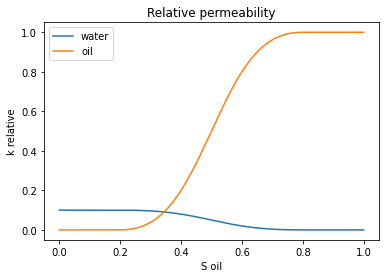

In [9]:
ss = np.linspace(0, 1, 200)
k_rels_w = [prop.k_rel_w(1-s) for s in ss]
k_rels_o = [prop.k_rel_o(s) for s in ss]
plt.plot(ss, k_rels_w, label='water')
plt.plot(ss, k_rels_o, label='oil')
plt.xlabel('S oil')
plt.ylabel("k relative")
plt.title('Relative permeability')
plt.legend()
plt.show()

In [10]:
from reservoir import ResState

In [11]:
p = ResState(p, p_0, prop)
s_o = ResState(s_o, s_b, prop)
s_w = ResState(s_w, 1 - s_b, prop)

Дальше немного сложенее - теперь нужно вводить межблочную относительную проницаемость

Раньше `i` и `j` это номера соседних ячеек по единственной оси.
Теперь это будет номер "межблока", например (0.5, 1).
Это всё реализованно в свойствах резервуара

Небольшие изменения потерпит матарица, отвечающая за лапласиан

In [12]:
from reservoir import get_lapl_one_ph

In [13]:
lapl_w = get_lapl_one_ph(p=p, s=s_w, ph='w', prop=prop)
lapl_o = get_lapl_one_ph(p=p, s=s_o, ph='o', prop=prop)

Также изменился вектор для граничных условий

In [14]:
from reservoir import get_q_bound

In [15]:
q_bound_w = get_q_bound(p, s_w, 'w', prop)
q_bound_o = get_q_bound(p, s_o, 'o', prop)

Теперь про моделирование скважины

Закинем координаты скважин

In [16]:
pos_r = {(12, 8): 0.1, (18, 21): 0.1}
p_well = np.zeros((nx, ny))
delta_p_well = -200 * 6894.
delta_p_vec = np.ones((nx*ny, 1)) * delta_p_well

In [17]:
from reservoir import get_j_matrix

In [18]:
j_o = get_j_matrix(p=p, s=s_o, pos_r=pos_r, ph='o', prop=prop)
j_w = get_j_matrix(p=p, s=s_w, pos_r=pos_r, ph='w', prop=prop)

И последний штрих - перед производной по времени есть $V_b\big(S_o c_o + S_w c_w  +1\cdot c_r\big)$. Назовём это `dt_comp_sat`

Кстати, у нас теперь `2d` и теперь нужно делать `.reshape`

In [19]:
dt_comp_sat = dx * dy * d *(s_o.v * c_o + s_w.v * c_w + np.ones((nx*ny, 1)) * c_r)

Закаидываем пареметры для запуска сессии и записи истории

In [20]:
n_iter = int(2)
p_ex = np.ones((nx, 1)) * p_0
t = 0
xs = list((np.linspace(0, nx-1, nx) + dx/2) * dx)
plot_freq = int(1)
times = []
p_well_hist = {}
s_o_well_hist = {}
q_o_hist = {}
q_w_hist = {}
for w in pos_r:
    p_well_hist[w] = []
    s_o_well_hist[w] = []
    q_o_hist[w] = []
    q_w_hist[w] = []

In [21]:
from tqdm import tqdm

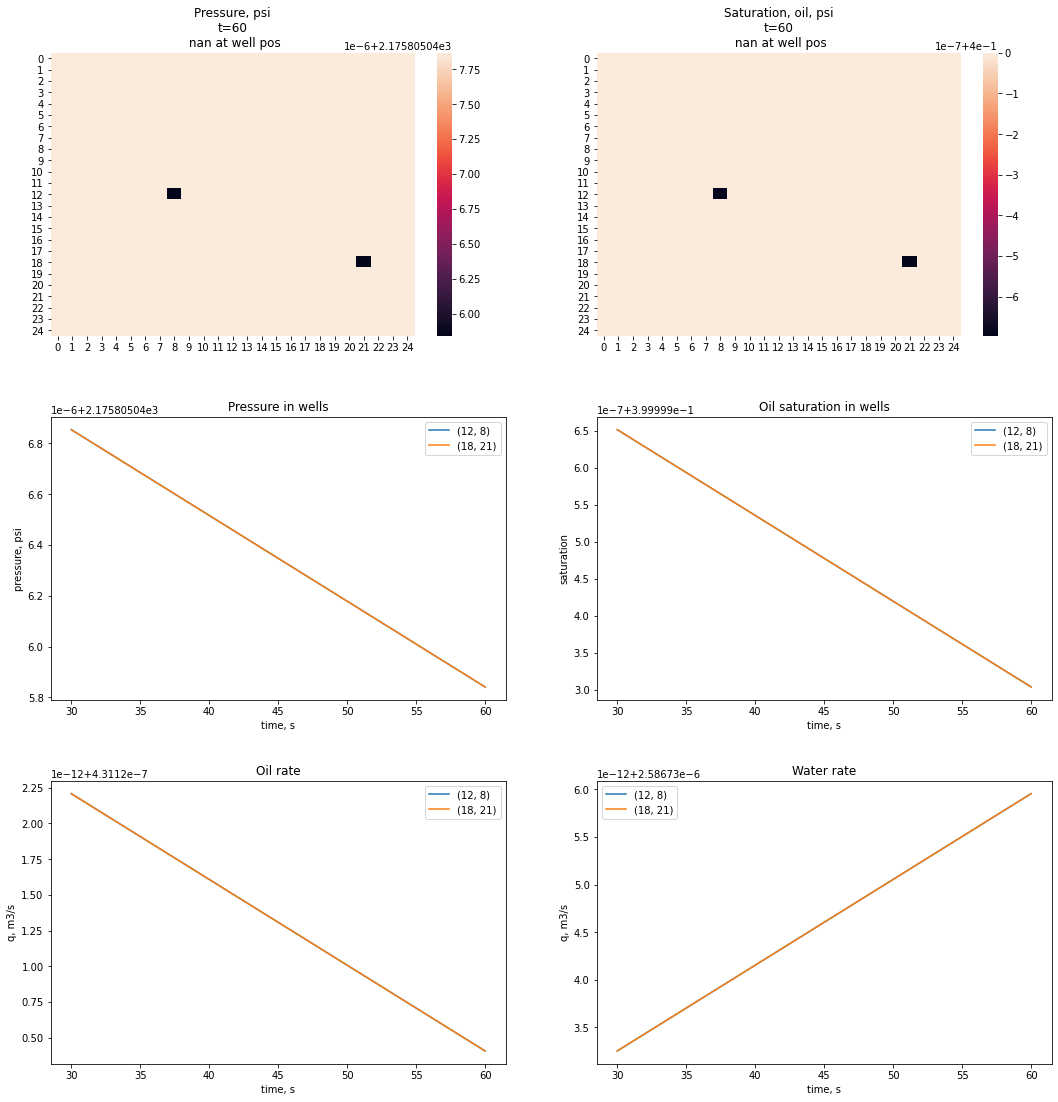

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]

Wall time: 3.23 s


In [22]:
%%time
for i in tqdm(range(1, n_iter+1)):
    # gonna increase time step
    # matrixes depends on saturation
    dt_comp_sat = dt_comp_sat = dx * dy * d *(s_o.v * c_o + s_w.v * c_w + np.ones((nx*ny, 1)) * c_r)
    dt_comp_sat *= dx * dy * d
    j_o = get_j_matrix(p=p, s=s_o, pos_r=pos_r, ph='o', prop=prop)
    j_w = get_j_matrix(p=p, s=s_w, pos_r=pos_r, ph='w', prop=prop)
    lapl_w = get_lapl_one_ph(p=p, s=s_w, ph='w', prop=prop)
    lapl_o = get_lapl_one_ph(p=p, s=s_o, ph='o', prop=prop)
    q_bound_w = get_q_bound(p, s_w, 'w', prop)
    q_bound_o = get_q_bound(p, s_o, 'o', prop)
    # matrix for implicit pressure
    a = phi * np.eye(nx*ny) * dt_comp_sat - (lapl_w + lapl_o) * dt
    #right hand state for ax = b
    b = phi * dt_comp_sat * p.v + q_bound_w*dt + q_bound_o*dt 
    b += (j_o * B_o + j_w * B_w) * delta_p_vec * dt
    # upd time stamp
    t += dt
    # solve p
    p_new = np.linalg.solve(a, b)
    a = dx*dy*d * phi *(np.ones((nx * ny, 1)) + (c_r + c_o) * (p_new - p.v))
    b = phi * dx*dy*d * s_o.v + dt * (lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec)
    # upd target values
    s_o = ResState((b / a), s_b, prop) 
    s_w = ResState(np.ones((nx*ny, 1)) - s_o.v, 1 - s_b, prop) 
    p = ResState(p_new, p_0, prop)
    if i % plot_freq == 0:
        
        q_o = ((-1) * j_o * (delta_p_vec)).reshape((nx, ny))
        q_w = ((-1) * j_w * (delta_p_vec)).reshape((nx, ny))
        
        # gonna set wells as nan to see gradient
        p_v_disp = p.v.reshape((nx, ny)).copy() / 6894.
        s_o_disp = s_o.v.reshape((nx, ny)).copy()
        
        times.append(t)
        for w in pos_r:
            p_well_hist[w].append(p[w] / 6894.)
            s_o_well_hist[w].append(s_o[w])
            q_o_hist[w].append(q_o[w])
            q_w_hist[w].append(q_w[w])
            # set wells as nan to see gradient
            # p_v_disp[w] = np.nan
            # s_o_disp[w] = np.nan
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
        f.tight_layout(pad=6.0)
        
        sns.heatmap(p_v_disp, ax=ax[0][0], cbar=True)
        ax[0][0].set_title(f'Pressure, psi\nt={t}\n nan at well pos')
        
        sns.heatmap(s_o_disp, ax=ax[0][1], cbar=True, fmt=".2f")
        ax[0][1].set_title(f'Saturation, oil, psi\nt={t}\n nan at well pos')
        
        for w in pos_r:
            ax[1][0].plot(times, p_well_hist[w] , label=f'{w}')
            ax[1][1].plot(times, s_o_well_hist[w] , label=f'{w}')
            ax[2][0].plot(times, q_o_hist[w] , label=f'{w}')
            ax[2][1].plot(times, q_w_hist[w] , label=f'{w}')
        ax[1][0].set_xlabel('time, s')
        ax[1][0].set_ylabel('pressure, psi')
        ax[1][0].set_title('Pressure in wells')
        ax[1][0].legend()
        
        ax[1][1].set_xlabel('time, s')
        ax[1][1].set_ylabel('saturation')
        ax[1][1].set_title('Oil saturation in wells')
        ax[1][1].legend()
        
        ax[2][0].set_xlabel('time, s')
        ax[2][0].set_ylabel('q, m3/s')
        ax[2][0].set_title('Oil rate')
        ax[2][0].legend()
        
        ax[2][1].set_xlabel('time, s')
        ax[2][1].set_ylabel('q, m3/s')
        ax[2][1].set_title('Water rate')
        ax[2][1].legend()
                
        plt.show()

In [ ]:
dsdt = (lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec) - phi *dx*dy*d * dp/dt *(c_o + c_r)

<AxesSubplot:>

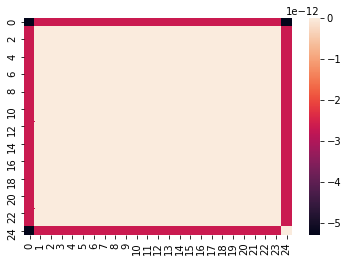

In [23]:
sns.heatmap((lapl_o.dot(p_new) + q_bound_o).reshape((25, 25)))

In [ ]:
sns.heatmap(dsdt.reshape((25, 25)))

In [ ]:
sns.heatmap((s_w.v + s_o.v).reshape((25, 25)))

In [ ]:
a = phi * np.eye(nx*ny) * dt_comp_sat - (lapl_w+lapl_o) * dt
b = phi * dt_comp_sat * p.v + q_bound_w*dt + q_bound_o*dt 
b += (j_o * B_o + j_w * B_w) * delta_p_vec * dt
for i in tqdm(range(1, n_iter)):
    a = phi * np.eye(nx*ny) * dt_comp_sat - (lapl_w+lapl_o) * dt
    #right hand state for ax = b
    b = phi * dt_comp_sat * p.v + q_bound_w*dt + q_bound_o*dt 
    b += (j_o * B_o + j_w * B_w) * delta_p_vec * dt
    # upd time stamp
    t += dt
    # solve p
    p_new = np.linalg.solve(a, b)
    
    a = dx*dy*d * phi *(np.ones((nx * ny, 1)) + (c_r + c_o) * (p_new - p.v))
    b = phi * dx*dy*d * s_o.v + dt * (lapl_o.dot(p_new) + q_bound_o + j_o * B_o * delta_p_vec)
    # upd target values
    s_o = ResState((b / a), s_b) 
    s_w = ResState(np.ones((nx*ny, 1)) - s_o.v, 1 - s_b) 
    p = ResState(p_new, p_0)

In [ ]:
for i in tqdm(range(1, n_iter)):
    dt_comp_sat = dt_comp_sat = dx * dy * d *(s_o.v * c_o + s_w.v * c_w + np.ones((nx*ny, 1)) * c_r)
    dt_comp_sat *= dx * dy * d
    j_o = get_j_matrix(p=p, s=s_o, mu=mu_o, k=k, B=B_o, pos_r=pos_r, r_ref=r_ref, ph='o')
    j_w = get_j_matrix(p=p, s=s_w, mu=mu_w, k=k, B=B_w, pos_r=pos_r, r_ref=r_ref, ph='w')
    lapl_w = get_lapl_one_ph(p, s_w, mu_w, k, d, dx, dy, 'w')
    lapl_o = get_lapl_one_ph(p, s_o, mu_o, k, d, dx, dy, 'o')
    q_bound_w = get_q_bound(p, s_w, 'w', mu_w)
    q_bound_o = get_q_bound(p, s_o, 'o', mu_o)

In [ ]:
import multiprocessing
import imp
import mult_func as mf

imp.reload(mf)

In [ ]:
from multiprocessing import Pool
# import workers
if __name__ ==  '__main__': 
    num_processors = 3
    p=Pool(processes = num_processors)
    output = p.map(mf.worker,[i for i in range(0,3)])
    print(output)

In [ ]:
lalp_o = get_lapl_one_ph(p, s_o, mu_o, k, d, dx, dy, 'o')

In [ ]:
n_th = 2

In [ ]:
if __name__ ==  '__main__': 
    l_mth = mf.get_lapl_one_ph_muth(p, s_o, mu_o, k, d, dx, dy, ph='o', n_th=8)

In [ ]:
from mpi4py import MPI

In [ ]:
import mpi4py